In [4]:

import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


In [5]:
# Actor–Critic (A2C-style) Network
class ActorCritic(nn.Module):
    def __init__(self, obs_dim, n_actions):
        super(ActorCritic, self).__init__()
        
        
        self.common = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU()
        )
        
        # Actor head
        self.actor = nn.Sequential(
            nn.Linear(128, n_actions),
            nn.Softmax(dim=1)
        )
        
        # Critic head
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        base = self.common(x)
        probs = self.actor(base)
        value = self.critic(base)
        return probs, value


In [6]:
env = gym.make("CartPole-v1")

obs_dim = env.observation_space.shape[0]
n_actions = env.action_space.n

# Model + Optimizer
model = ActorCritic(obs_dim, n_actions)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Hyperparameters
gamma = 0.99
episodes = 500
reward_history = []


In [10]:
for episode in range(episodes):
    state = env.reset()[0]
    
    log_probs = []
    values = []
    rewards = []
    actor_loss_history = []
    critic_loss_history = []

    # Generate an episode
    while True:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        probs, value = model(state_tensor)
        
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()

        log_probs.append(dist.log_prob(action))
        values.append(value.squeeze(0))
        
        next_state, reward, done, _, _ = env.step(action.item())
        
        rewards.append(reward)
        state = next_state
        
        if done:
            break
    
    # Compute returns
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)

    returns = torch.FloatTensor(returns)
    returns = returns.unsqueeze(-1)
    values = torch.stack(values)
    log_probs = torch.stack(log_probs)

    # Advantage
    advantage = returns - values.detach()

    # Losses
    actor_loss = -(log_probs * advantage).sum()
    critic_loss = nn.MSELoss()(values, returns)
    loss = actor_loss + critic_loss
    
    # Update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    reward_history.append(sum(rewards))
    actor_loss_history.append(actor_loss.item())
    critic_loss_history.append(critic_loss.item())
    print(f"Episode {episode+1}, Reward: {sum(rewards):.2f}")
# Saving Model
MODEL_PATH = "actor_critic_cartpole.pth"

torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict()
}, MODEL_PATH)

print(f"Model saved to {MODEL_PATH}")



Episode 1, Reward: 46.00
Episode 2, Reward: 68.00
Episode 3, Reward: 58.00
Episode 4, Reward: 42.00
Episode 5, Reward: 32.00
Episode 6, Reward: 30.00
Episode 7, Reward: 73.00
Episode 8, Reward: 38.00
Episode 9, Reward: 99.00
Episode 10, Reward: 20.00
Episode 11, Reward: 89.00
Episode 12, Reward: 93.00
Episode 13, Reward: 57.00
Episode 14, Reward: 39.00
Episode 15, Reward: 34.00
Episode 16, Reward: 63.00
Episode 17, Reward: 101.00
Episode 18, Reward: 45.00
Episode 19, Reward: 29.00
Episode 20, Reward: 32.00
Episode 21, Reward: 65.00
Episode 22, Reward: 59.00
Episode 23, Reward: 35.00
Episode 24, Reward: 54.00
Episode 25, Reward: 110.00
Episode 26, Reward: 47.00
Episode 27, Reward: 54.00
Episode 28, Reward: 29.00
Episode 29, Reward: 55.00
Episode 30, Reward: 59.00
Episode 31, Reward: 48.00
Episode 32, Reward: 36.00
Episode 33, Reward: 41.00
Episode 34, Reward: 23.00
Episode 35, Reward: 44.00
Episode 36, Reward: 48.00
Episode 37, Reward: 67.00
Episode 38, Reward: 71.00
Episode 39, Reward:

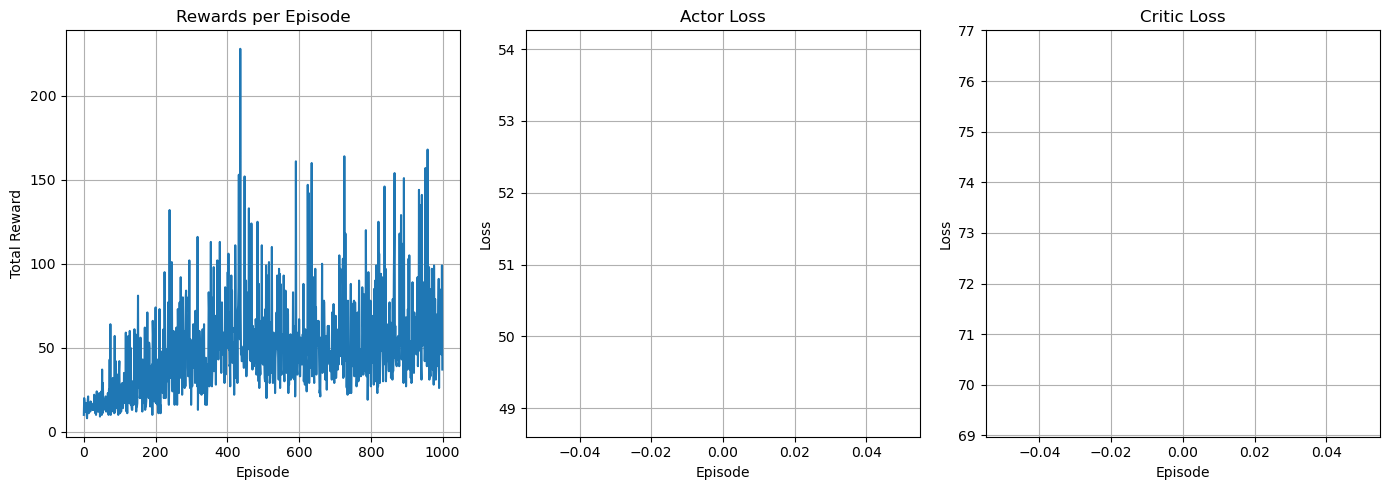

In [11]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.plot(reward_history)
plt.title("Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(actor_loss_history)
plt.title("Actor Loss")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(critic_loss_history)
plt.title("Critic Loss")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.grid(True)

plt.tight_layout()
plt.show()

In [9]:
checkpoint = torch.load("actor_critic_cartpole.pth")

test_model = ActorCritic(obs_dim, n_actions)
test_model.load_state_dict(checkpoint["model_state_dict"])
test_model.eval()
print("Model loaded!")


Model loaded!
